In [1]:
!pip install -q torch torchvision tqdm matplotlib scikit-learn tensorflow albumentations opencv-python einops timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import timm
from einops import rearrange
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

Using device: cuda


In [5]:
class PolypDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0  # Normalize to [0, 1]
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask.unsqueeze(0)  # Adding channel dimension for mask

def get_transforms(img_size=256):
    train_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return train_transform, val_transform

In [7]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MultiLayerPerceptron(
            dim, int(dim * mlp_ratio), dim, dropout
        )
        
    def forward(self, x):
        # x shape: [seq_len, batch, dim]
        residual = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = residual + x
        
        residual = x
        x = self.norm2(x)
        x = residual + self.mlp(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        # x: [batch, channels, height, width]
        x = self.proj(x)  # [batch, embed_dim, grid, grid]
        x = x.flatten(2)  # [batch, embed_dim, n_patches]
        x = x.transpose(1, 2)  # [batch, n_patches, embed_dim]
        return x

class TransformerSegmentationModel(nn.Module):
    def __init__(
        self, 
        img_size=256, 
        patch_size=16, 
        in_channels=3, 
        out_channels=1,
        embed_dim=768, 
        depth=12, 
        heads=12, 
        mlp_ratio=4, 
        dropout=0.1
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size, patch_size, in_channels, embed_dim
        )
        self.n_patches = self.patch_embed.n_patches
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))
        
        # Class token (CLS token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer encoder
        self.transformer = TransformerEncoder(
            embed_dim, depth, heads, mlp_ratio, dropout
        )
        
        # Layer norm before decoder
        self.norm = nn.LayerNorm(embed_dim)
        
        # Transformer decoder (for segmentation)
        self.decoder_embed = nn.Linear(embed_dim, embed_dim // 2)
        self.decoder_blocks = TransformerEncoder(
            embed_dim // 2, depth // 2, heads // 2, mlp_ratio, dropout
        )
        self.decoder_norm = nn.LayerNorm(embed_dim // 2)
        self.decoder_pred = nn.Linear(embed_dim // 2, (patch_size ** 2) * out_channels)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Initialize patch embedding projection
        nn.init.normal_(self.patch_embed.proj.weight, std=0.02)
        nn.init.constant_(self.patch_embed.proj.bias, 0)
        
    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)  # [batch, n_patches, embed_dim]
        
        # Add class token
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)  # [batch, 1 + n_patches, embed_dim]
        
        # Add position embedding
        x = x + self.pos_embed
        
        # Apply transformer encoder (convert to [seq_len, batch, dim] for nn.MultiheadAttention)
        x = x.transpose(0, 1)  # [1 + n_patches, batch, embed_dim]
        x = self.transformer(x)
        x = x.transpose(0, 1)  # [batch, 1 + n_patches, embed_dim]
        
        # Apply layer norm
        x = self.norm(x)
        
        # Segmentation decoder (use only patch tokens, not CLS token)
        x = x[:, 1:]  # [batch, n_patches, embed_dim]
        
        # Project to decoder dimension
        x = self.decoder_embed(x)  # [batch, n_patches, embed_dim // 2]
        
        # Apply transformer decoder
        x = x.transpose(0, 1)  # [n_patches, batch, embed_dim // 2]
        x = self.decoder_blocks(x)
        x = x.transpose(0, 1)  # [batch, n_patches, embed_dim // 2]
        
        # Apply decoder norm
        x = self.decoder_norm(x)
        
        # Predict per-patch segmentation
        x = self.decoder_pred(x)  # [batch, n_patches, patch_size*patch_size*out_channels]
        
        # Reshape to image
        grid_size = self.img_size // self.patch_size
        x = x.reshape(batch_size, grid_size, grid_size, self.patch_size, self.patch_size, -1)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(batch_size, -1, self.img_size, self.img_size)
        
        # Apply sigmoid activation
        x = torch.sigmoid(x)
        
        return x

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        return 1 - dice

class IoULoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(IoULoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        total = (pred_flat + target_flat).sum()
        union = total - intersection
        
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        return 1 - iou

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.dice_loss = DiceLoss()
        self.iou_loss = IoULoss()
        
    def forward(self, pred, target):
        dice_loss = self.dice_loss(pred, target)
        iou_loss = self.iou_loss(pred, target)
        return self.alpha * dice_loss + self.beta * iou_loss

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_dice = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for inputs, masks in pbar:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item()})
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        dice_scores = []
        iou_scores = []
        
        pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
        with torch.no_grad():
            for inputs, masks in pbar:
                inputs = inputs.to(device)
                masks = masks.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                pred = (outputs > 0.5).float()
                dice = 1 - DiceLoss()(pred, masks)
                iou = 1 - IoULoss()(pred, masks)
                
                dice_scores.append(dice.item())
                iou_scores.append(iou.item())
                running_loss += loss.item() * inputs.size(0)
                pbar.set_postfix({'loss': loss.item(), 'dice': dice.item(), 'iou': iou.item()})
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_dice = np.mean(dice_scores)
        epoch_val_iou = np.mean(iou_scores)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_dice'].append(epoch_val_dice)
        history['val_iou'].append(epoch_val_iou)
        
        print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
        print(f'Val Dice: {epoch_val_dice:.4f}, Val IoU: {epoch_val_iou:.4f}')
        
        # Save best model
        if epoch_val_dice > best_dice:
            best_dice = epoch_val_dice
            torch.save(model.state_dict(), 'best_transformer_model.pth')
            print(f'Model saved with Dice score: {best_dice:.4f}')
        
        # Update learning rate
        if scheduler:
            scheduler.step(epoch_val_loss)
    
    return model, history

In [10]:
def calculate_metrics(model, data_loader):
    model.eval()
    dice_scores = []
    iou_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    
    with torch.no_grad():
        for inputs, masks in tqdm(data_loader, desc='Calculating metrics'):
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            outputs = model(inputs)
            pred = (outputs > 0.5).float()
            
            # Convert tensors to numpy arrays for metrics calculation
            pred_np = pred.cpu().numpy().flatten()
            masks_np = masks.cpu().numpy().flatten()
            
            # Binary masks for accuracy, precision, recall, etc.
            pred_binary = (pred_np > 0.5).astype(np.uint8)
            masks_binary = (masks_np > 0.5).astype(np.uint8)
            
            # Calculate metrics
            dice = 1 - DiceLoss()(pred, masks)
            iou = 1 - IoULoss()(pred, masks)
            accuracy = accuracy_score(masks_binary, pred_binary)
            precision = precision_score(masks_binary, pred_binary, zero_division=1)
            recall = recall_score(masks_binary, pred_binary, zero_division=1)
            
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
    
    return {
        'dice': np.mean(dice_scores),
        'iou': np.mean(iou_scores),
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores)
    }

In [11]:
def visualize_predictions(model, data_loader, num_samples=5):
    model.eval()
    images, masks, preds = [], [], []
    
    with torch.no_grad():
        for inputs, target_masks in data_loader:
            if len(images) >= num_samples:
                break
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            pred_masks = (outputs > 0.5).float()
            
            # Store batch results
            for i in range(inputs.size(0)):
                if len(images) >= num_samples:
                    break
                    
                # Convert from tensor to numpy for visualization
                img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                img = img.astype(np.uint8)
                
                mask = target_masks[i, 0].cpu().numpy()
                pred = pred_masks[i, 0].cpu().numpy()
                
                images.append(img)
                masks.append(mask)
                preds.append(pred)
    
    # Plot the results
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Predicted mask
        axes[i, 2].imshow(preds[i], cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('polyp_segmentation_results.png')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Dice Score')
    plt.plot(history['val_iou'], label='IoU Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

Train images: 600
Validation images: 200
Test images: 200
Epoch 1/50
----------


Validation Epoch 1: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s, loss=0.849, dice=0.259, iou=0.149]  


Train Loss: 0.7635, Val Loss: 0.8427
Val Dice: 0.1877, Val IoU: 0.1048
Model saved with Dice score: 0.1877
Epoch 2/50
----------


Validation Epoch 2: 100%|██████████| 25/25 [00:04<00:00,  6.06it/s, loss=0.808, dice=0.259, iou=0.149]


Train Loss: 0.7304, Val Loss: 0.7296
Val Dice: 0.3554, Val IoU: 0.2201
Model saved with Dice score: 0.3554
Epoch 3/50
----------


Validation Epoch 3: 100%|██████████| 25/25 [00:04<00:00,  5.51it/s, loss=0.803, dice=0.258, iou=0.148]


Train Loss: 0.7035, Val Loss: 0.7228
Val Dice: 0.3536, Val IoU: 0.2187
Epoch 4/50
----------


Validation Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s, loss=0.798, dice=0.261, iou=0.15] 


Train Loss: 0.6979, Val Loss: 0.7188
Val Dice: 0.3542, Val IoU: 0.2192
Epoch 5/50
----------


Validation Epoch 5: 100%|██████████| 25/25 [00:04<00:00,  5.22it/s, loss=0.796, dice=0.262, iou=0.151]


Train Loss: 0.6938, Val Loss: 0.7159
Val Dice: 0.3555, Val IoU: 0.2201
Model saved with Dice score: 0.3555
Epoch 6/50
----------


Validation Epoch 6: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.795, dice=0.263, iou=0.151]


Train Loss: 0.6894, Val Loss: 0.7147
Val Dice: 0.3557, Val IoU: 0.2202
Model saved with Dice score: 0.3557
Epoch 7/50
----------


Validation Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.795, dice=0.262, iou=0.151]


Train Loss: 0.6939, Val Loss: 0.7140
Val Dice: 0.3558, Val IoU: 0.2203
Model saved with Dice score: 0.3558
Epoch 8/50
----------


Validation Epoch 8: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s, loss=0.794, dice=0.262, iou=0.151]


Train Loss: 0.6849, Val Loss: 0.7134
Val Dice: 0.3559, Val IoU: 0.2204
Model saved with Dice score: 0.3559
Epoch 9/50
----------


Validation Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.04it/s, loss=0.783, dice=0.275, iou=0.16] 


Train Loss: 0.6923, Val Loss: 0.7085
Val Dice: 0.3616, Val IoU: 0.2244
Model saved with Dice score: 0.3616
Epoch 10/50
----------


Validation Epoch 10: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s, loss=0.783, dice=0.276, iou=0.16] 


Train Loss: 0.6918, Val Loss: 0.7073
Val Dice: 0.3626, Val IoU: 0.2251
Model saved with Dice score: 0.3626
Epoch 11/50
----------


Validation Epoch 11: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s, loss=0.783, dice=0.276, iou=0.16] 


Train Loss: 0.6843, Val Loss: 0.7070
Val Dice: 0.3627, Val IoU: 0.2253
Model saved with Dice score: 0.3627
Epoch 12/50
----------


Validation Epoch 12: 100%|██████████| 25/25 [00:04<00:00,  5.15it/s, loss=0.782, dice=0.276, iou=0.16] 


Train Loss: 0.6878, Val Loss: 0.7068
Val Dice: 0.3627, Val IoU: 0.2253
Epoch 13/50
----------


Validation Epoch 13: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, loss=0.781, dice=0.278, iou=0.161]


Train Loss: 0.6927, Val Loss: 0.7063
Val Dice: 0.3632, Val IoU: 0.2256
Model saved with Dice score: 0.3632
Epoch 14/50
----------


Validation Epoch 14: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.78, dice=0.279, iou=0.162] 


Train Loss: 0.6905, Val Loss: 0.7061
Val Dice: 0.3633, Val IoU: 0.2257
Model saved with Dice score: 0.3633
Epoch 15/50
----------


Validation Epoch 15: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.815, dice=0.237, iou=0.134]


Train Loss: 0.6884, Val Loss: 0.7288
Val Dice: 0.3367, Val IoU: 0.2064
Epoch 16/50
----------


Validation Epoch 16: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s, loss=0.804, dice=0.25, iou=0.143] 


Train Loss: 0.6910, Val Loss: 0.7182
Val Dice: 0.3489, Val IoU: 0.2153
Epoch 17/50
----------


Validation Epoch 17: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.797, dice=0.258, iou=0.148]


Train Loss: 0.6845, Val Loss: 0.7142
Val Dice: 0.3536, Val IoU: 0.2187
Epoch 18/50
----------


Validation Epoch 18: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.797, dice=0.258, iou=0.148]


Train Loss: 0.6929, Val Loss: 0.7142
Val Dice: 0.3536, Val IoU: 0.2187
Epoch 19/50
----------


Validation Epoch 19: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.797, dice=0.258, iou=0.148]


Train Loss: 0.6897, Val Loss: 0.7137
Val Dice: 0.3541, Val IoU: 0.2190
Epoch 20/50
----------


Validation Epoch 20: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6892, Val Loss: 0.7131
Val Dice: 0.3549, Val IoU: 0.2196
Epoch 21/50
----------


Validation Epoch 21: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6907, Val Loss: 0.7131
Val Dice: 0.3548, Val IoU: 0.2195
Epoch 22/50
----------


Validation Epoch 22: 100%|██████████| 25/25 [00:04<00:00,  5.34it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6879, Val Loss: 0.7131
Val Dice: 0.3549, Val IoU: 0.2196
Epoch 23/50
----------


Validation Epoch 23: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6886, Val Loss: 0.7131
Val Dice: 0.3548, Val IoU: 0.2195
Epoch 24/50
----------


Validation Epoch 24: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.795, dice=0.26, iou=0.15]  


Train Loss: 0.6885, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 25/50
----------


Validation Epoch 25: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s, loss=0.795, dice=0.26, iou=0.15]  


Train Loss: 0.6935, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 26/50
----------


Validation Epoch 26: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6864, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 27/50
----------


Validation Epoch 27: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6885, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 28/50
----------


Validation Epoch 28: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6956, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 29/50
----------


Validation Epoch 29: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6917, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 30/50
----------


Validation Epoch 30: 100%|██████████| 25/25 [00:04<00:00,  5.18it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6922, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 31/50
----------


Validation Epoch 31: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6891, Val Loss: 0.7127
Val Dice: 0.3553, Val IoU: 0.2199
Epoch 32/50
----------


Validation Epoch 32: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6903, Val Loss: 0.7127
Val Dice: 0.3552, Val IoU: 0.2199
Epoch 33/50
----------


Validation Epoch 33: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6814, Val Loss: 0.7127
Val Dice: 0.3552, Val IoU: 0.2199
Epoch 34/50
----------


Validation Epoch 34: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6845, Val Loss: 0.7127
Val Dice: 0.3552, Val IoU: 0.2199
Epoch 35/50
----------


Validation Epoch 35: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, loss=0.796, dice=0.259, iou=0.149]


Train Loss: 0.6925, Val Loss: 0.7127
Val Dice: 0.3552, Val IoU: 0.2199
Epoch 36/50
----------


Validation Epoch 36: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6859, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 37/50
----------


Validation Epoch 37: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6938, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 38/50
----------


Validation Epoch 38: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6897, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 39/50
----------


Validation Epoch 39: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6918, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 40/50
----------


Validation Epoch 40: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6906, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 41/50
----------


Validation Epoch 41: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6876, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 42/50
----------


Validation Epoch 42: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6840, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 43/50
----------


Validation Epoch 43: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6933, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 44/50
----------


Validation Epoch 44: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6912, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 45/50
----------


Validation Epoch 45: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6934, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 46/50
----------


Validation Epoch 46: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6956, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 47/50
----------


Validation Epoch 47: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6907, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 48/50
----------


Validation Epoch 48: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6948, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 49/50
----------


Validation Epoch 49: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6932, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201
Epoch 50/50
----------


Validation Epoch 50: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.796, dice=0.26, iou=0.149] 


Train Loss: 0.6931, Val Loss: 0.7125
Val Dice: 0.3555, Val IoU: 0.2201


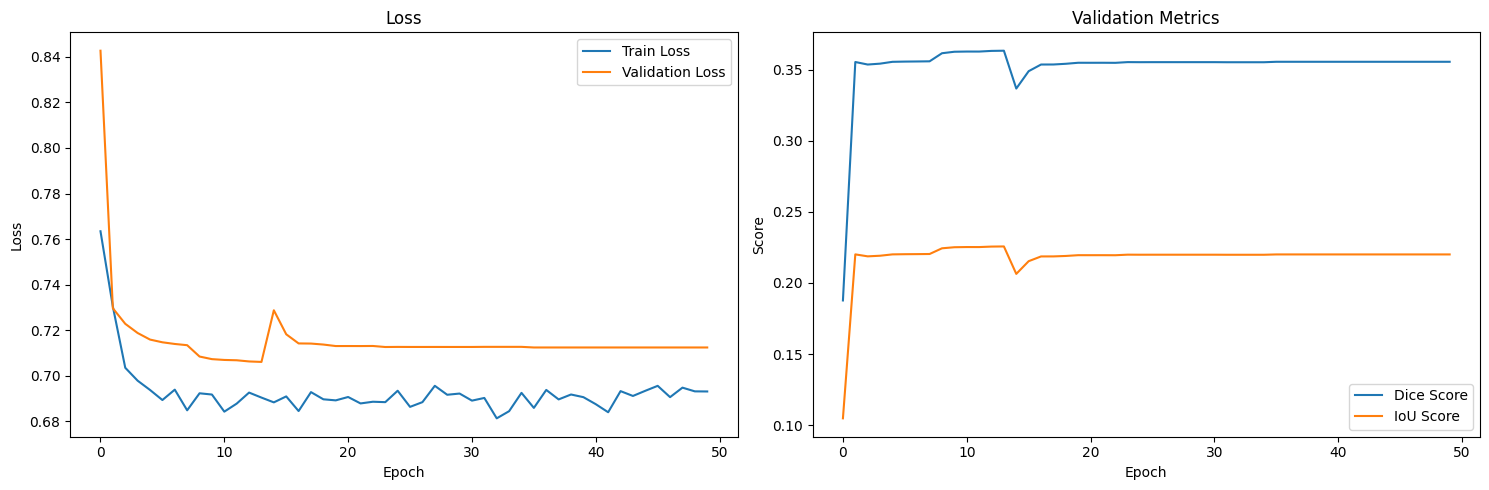

/tmp/ipykernel_31/1723598090.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))
Calculating metrics: 100%|█


Test Metrics:
dice: 0.3849
iou: 0.2404
accuracy: 0.6656
precision: 0.2753
recall: 0.6630


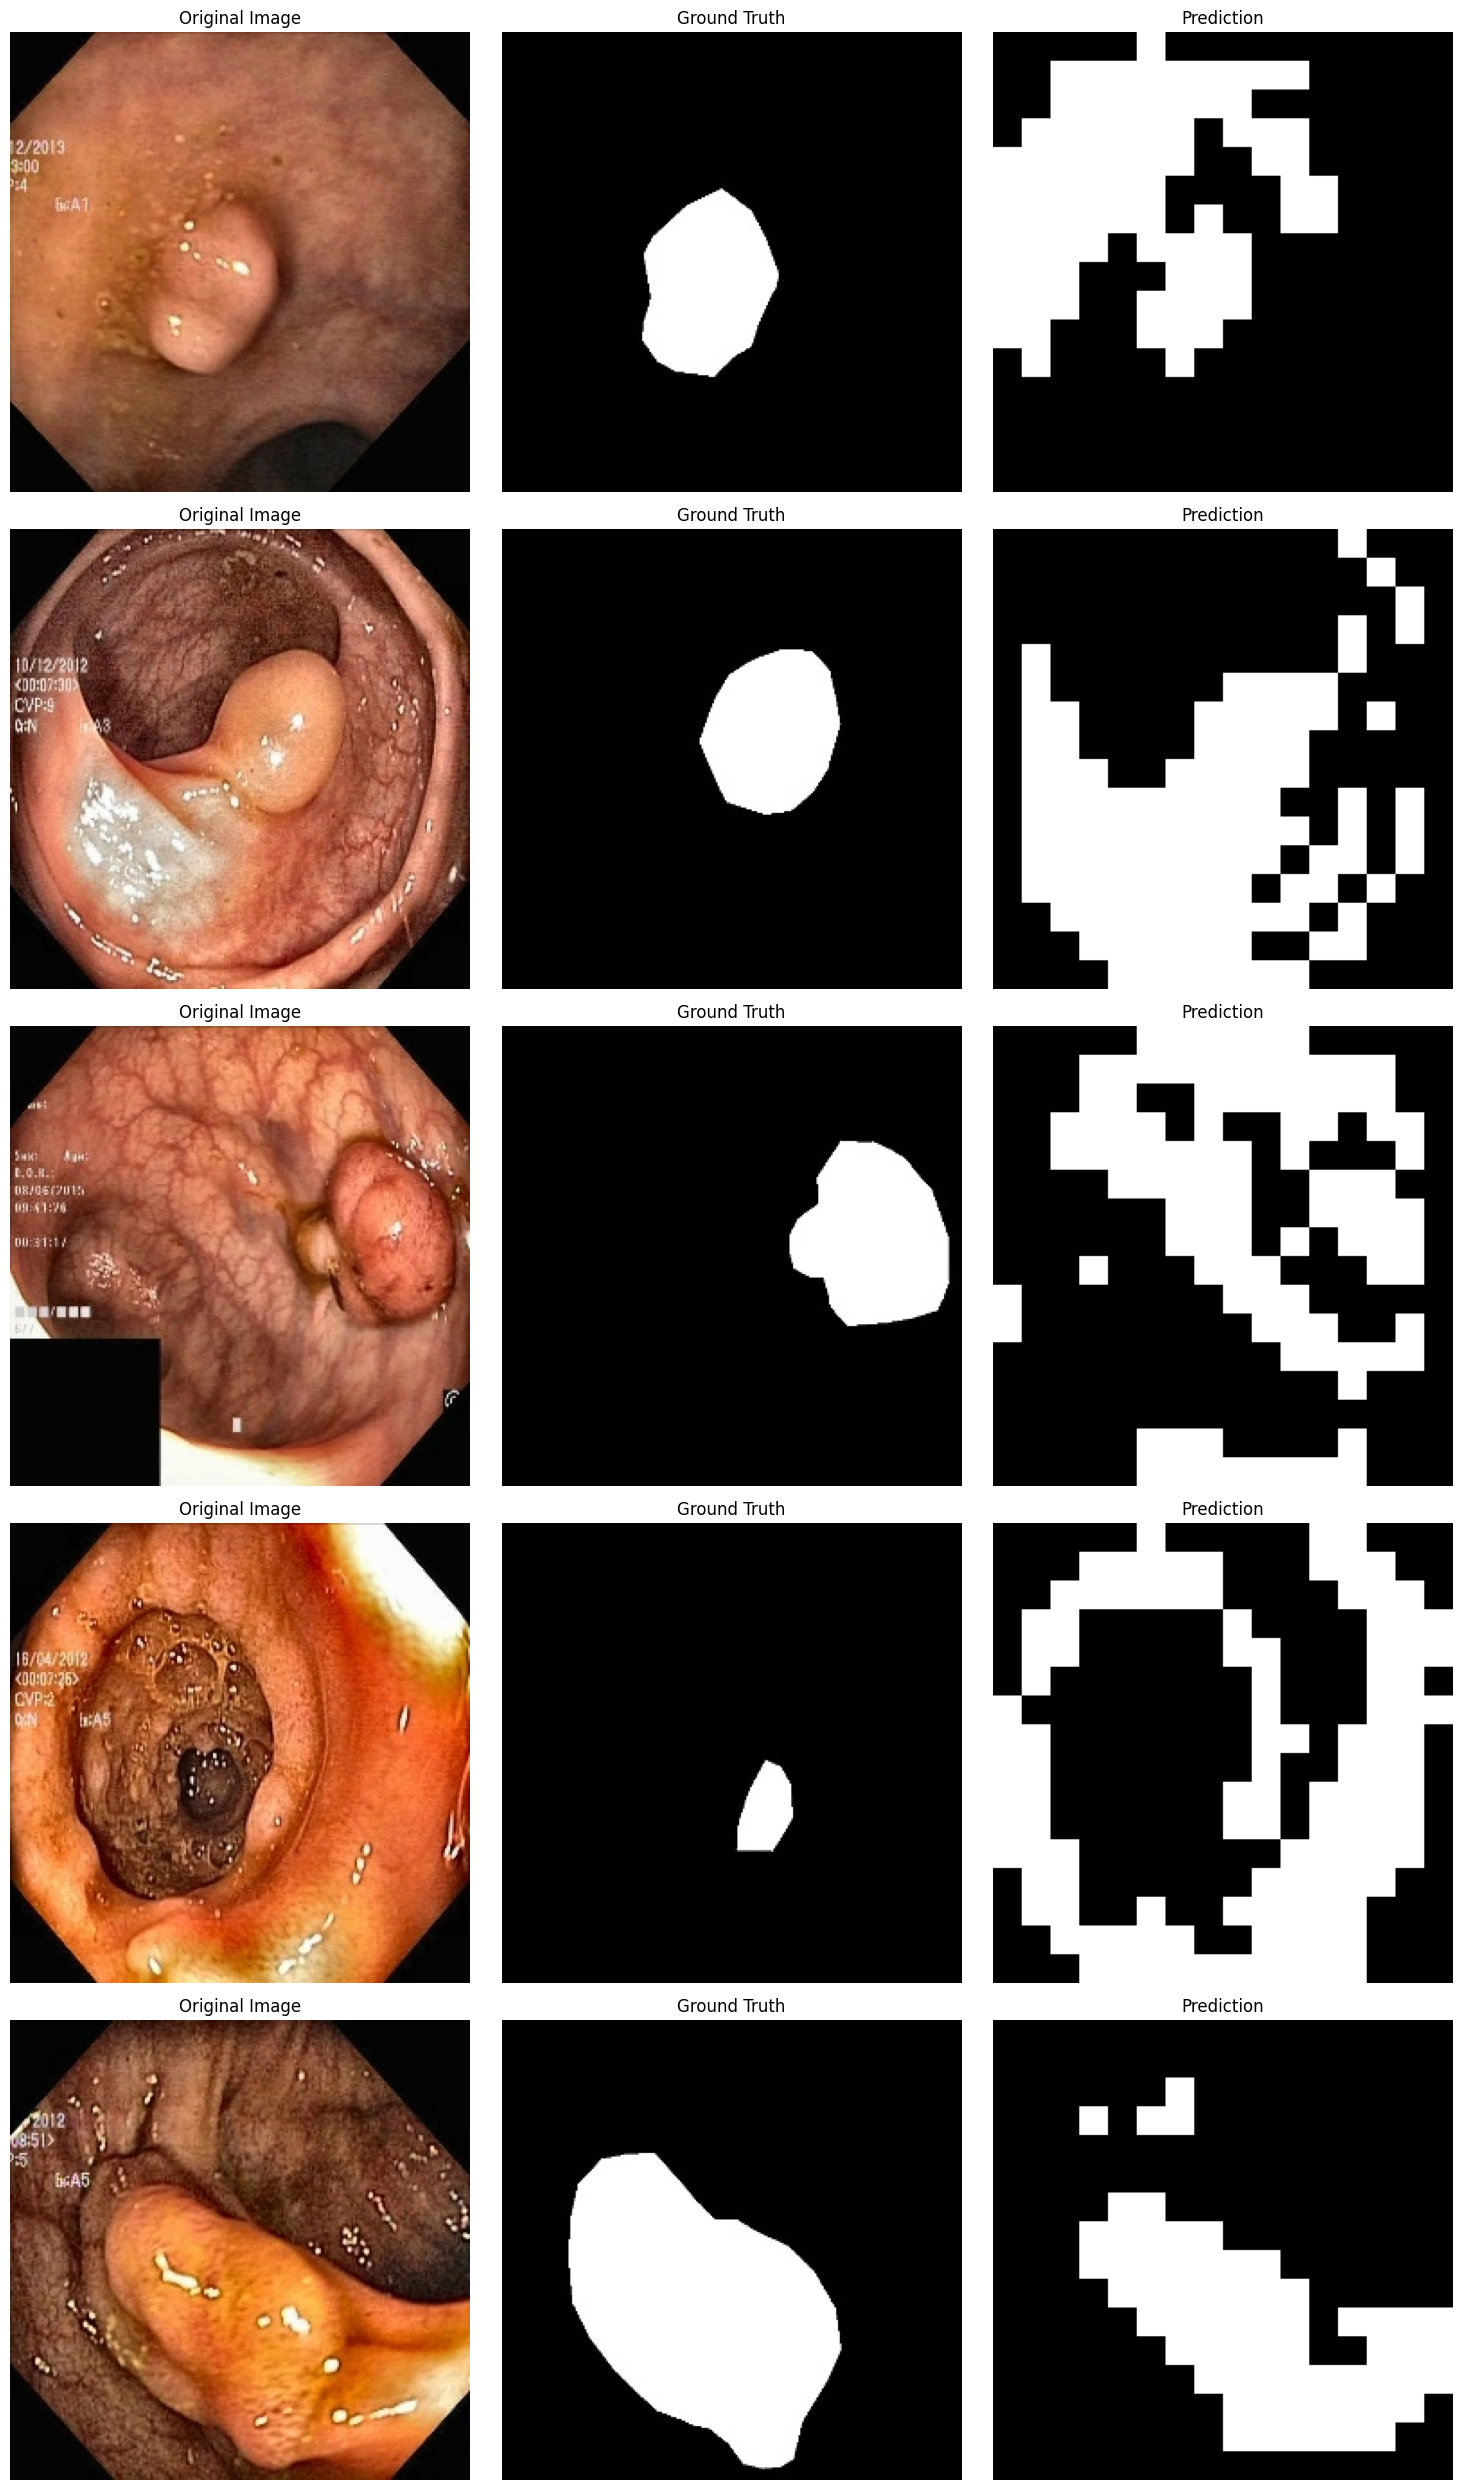

In [13]:
def main():
    # Set paths
    train_img_dir = '/kaggle/input/kvasier/new_data/train/images'
    train_mask_dir = '/kaggle/input/kvasier/new_data/train/masks'
    val_img_dir = '/kaggle/input/kvasier/new_data/valid/images'
    val_mask_dir = '/kaggle/input/kvasier/new_data/valid/masks'
    test_img_dir = '/kaggle/input/kvasier/new_data/test/images'
    test_mask_dir = '/kaggle/input/kvasier/new_data/test/masks'
    
    # Set hyperparameters
    img_size = 256
    batch_size = 8
    num_epochs = 50
    learning_rate = 5e-5  # Lower learning rate for transformer
    patch_size = 16  # Patch size for vision transformer
    
    # Get transforms
    train_transform, val_transform = get_transforms(img_size)
    
    # Create datasets
    train_dataset = PolypDataset(train_img_dir, train_mask_dir, transform=train_transform)
    val_dataset = PolypDataset(val_img_dir, val_mask_dir, transform=val_transform)
    test_dataset = PolypDataset(test_img_dir, test_mask_dir, transform=val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Create model
    model = TransformerSegmentationModel(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=3,
        out_channels=1,
        embed_dim=768,
        depth=12,
        heads=12,
        dropout=0.1
    ).to(device)
    
    # Loss function, optimizer and scheduler
    criterion = CombinedLoss(alpha=0.5, beta=0.5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # Print summary
    print(f"Train images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    print(f"Test images: {len(test_dataset)}")
    
    # Train model
    model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    # Plot training history
    plot_training_history(history)
    
    # Load best model
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    
    # Calculate metrics on test set
    test_metrics = calculate_metrics(model, test_loader)
    print("\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Visualize predictions
    visualize_predictions(model, test_loader, num_samples=5)

if __name__ == "__main__":
    main()

In [14]:
def predict_single_image(model, image_path, output_path=None):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transforms
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    augmented = transform(image=image)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = (output > 0.5).float()
    
    # Convert to numpy for visualization
    pred_mask = pred_mask[0, 0].cpu().numpy()
    
    # Resize mask to original image size
    pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        # Also save the binary mask as an image
        cv2.imwrite(output_path.replace('.png', '_mask.png'), (pred_mask * 255).astype(np.uint8))
    
    plt.show()
    
    return pred_mask

def compare_with_ground_truth(model, image_path, mask_path, output_path=None):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load ground truth mask
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = gt_mask / 255.0  # Normalize to [0, 1]
    
    # Apply transforms
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    augmented = transform(image=image)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = (output > 0.5).float()
    
    # Convert to numpy for visualization
    pred_mask = pred_mask[0, 0].cpu().numpy()
    
    # Resize mask to original image size
    pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Calculate metrics
    pred_binary = (pred_mask > 0.5).astype(np.uint8)
    gt_binary = (gt_mask > 0.5).astype(np.uint8)
    
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    
    dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum() + 1e-6)
    iou = intersection / (union + 1e-6)
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f'Prediction (Dice: {dice:.4f}, IoU: {iou:.4f})')
    plt.axis('off')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    
    return {'dice': dice, 'iou': iou}

In [ ]:
# To run the complete pipeline:
main()

# To predict on a single test image:
# model = TransformerSegmentationModel(img_size=256, patch_size=16, in_channels=3, out_channels=1).to(device)
# model.load_state_dict(torch.load('best_transformer_model.pth'))
# predict_single_image(model, 'new_data/test/images/0011.jpg', 'prediction_result.png')

# To compare prediction with ground truth:
# compare_with_ground_truth(model, 'new_data/test/images/0011.jpg', 'new_data/test/masks/0011.jpg', 'comparison_result.png')

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train images: 600
Validation images: 200
Test images: 200
Epoch 1/50
----------


Validation Epoch 1: 100%|██████████| 25/25 [00:04<00:00,  5.14it/s, loss=0.838, dice=0.229, iou=0.129] 


Train Loss: 0.7623, Val Loss: 0.7650
Val Dice: 0.3256, Val IoU: 0.1981
Model saved with Dice score: 0.3256
Epoch 2/50
----------


Validation Epoch 2: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s, loss=0.826, dice=0.232, iou=0.131] 


Train Loss: 0.7214, Val Loss: 0.7476
Val Dice: 0.3279, Val IoU: 0.1997
Model saved with Dice score: 0.3279
Epoch 3/50
----------


Validation Epoch 3: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s, loss=0.824, dice=0.23, iou=0.13]  


Train Loss: 0.7104, Val Loss: 0.7438
Val Dice: 0.3262, Val IoU: 0.1985
Epoch 4/50
----------


Validation Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.818, dice=0.236, iou=0.134]


Train Loss: 0.7073, Val Loss: 0.7330
Val Dice: 0.3368, Val IoU: 0.2064
Model saved with Dice score: 0.3368
Epoch 5/50
----------


Validation Epoch 5: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s, loss=0.817, dice=0.236, iou=0.134]


Train Loss: 0.6989, Val Loss: 0.7315
Val Dice: 0.3369, Val IoU: 0.2064
Model saved with Dice score: 0.3369
Epoch 6/50
----------


Validation Epoch 6: 100%|██████████| 25/25 [00:04<00:00,  5.20it/s, loss=0.8, dice=0.257, iou=0.147]  


Train Loss: 0.6909, Val Loss: 0.7172
Val Dice: 0.3531, Val IoU: 0.2182
Model saved with Dice score: 0.3531
Epoch 7/50
----------


Validation Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s, loss=0.795, dice=0.262, iou=0.151]


Train Loss: 0.6919, Val Loss: 0.7168
Val Dice: 0.3527, Val IoU: 0.2179
Epoch 8/50
----------


Validation Epoch 8: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.791, dice=0.266, iou=0.154]


Train Loss: 0.6925, Val Loss: 0.7149
Val Dice: 0.3547, Val IoU: 0.2190
Model saved with Dice score: 0.3547
Epoch 9/50
----------


Validation Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.777, dice=0.284, iou=0.166] 


Train Loss: 0.7098, Val Loss: 0.7803
Val Dice: 0.2786, Val IoU: 0.1634
Epoch 10/50
----------


Validation Epoch 10: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s, loss=0.789, dice=0.27, iou=0.156] 


Train Loss: 0.7467, Val Loss: 0.7150
Val Dice: 0.3554, Val IoU: 0.2193
Model saved with Dice score: 0.3554
Epoch 11/50
----------


Validation Epoch 11: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s, loss=0.798, dice=0.258, iou=0.148]


Train Loss: 0.7135, Val Loss: 0.7163
Val Dice: 0.3519, Val IoU: 0.2172
Epoch 12/50
----------


Validation Epoch 12: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6954, Val Loss: 0.7190
Val Dice: 0.3486, Val IoU: 0.2148
Epoch 13/50
----------


Validation Epoch 13: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.7009, Val Loss: 0.7189
Val Dice: 0.3486, Val IoU: 0.2148
Epoch 14/50
----------


Validation Epoch 14: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6972, Val Loss: 0.7189
Val Dice: 0.3484, Val IoU: 0.2147
Epoch 15/50
----------


Validation Epoch 15: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6963, Val Loss: 0.7189
Val Dice: 0.3484, Val IoU: 0.2147
Epoch 16/50
----------


Validation Epoch 16: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6865, Val Loss: 0.7189
Val Dice: 0.3485, Val IoU: 0.2148
Epoch 17/50
----------


Validation Epoch 17: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6902, Val Loss: 0.7189
Val Dice: 0.3485, Val IoU: 0.2147
Epoch 18/50
----------


Validation Epoch 18: 100%|██████████| 25/25 [00:04<00:00,  5.27it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6916, Val Loss: 0.7189
Val Dice: 0.3485, Val IoU: 0.2147
Epoch 19/50
----------


Validation Epoch 19: 100%|██████████| 25/25 [00:04<00:00,  5.14it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6917, Val Loss: 0.7189
Val Dice: 0.3485, Val IoU: 0.2147
Epoch 20/50
----------


Validation Epoch 20: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6950, Val Loss: 0.7189
Val Dice: 0.3485, Val IoU: 0.2147
Epoch 21/50
----------


Validation Epoch 21: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6929, Val Loss: 0.7190
Val Dice: 0.3484, Val IoU: 0.2147
Epoch 22/50
----------


Validation Epoch 22: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s, loss=0.8, dice=0.254, iou=0.146]  


Train Loss: 0.6943, Val Loss: 0.7189
Val Dice: 0.3484, Val IoU: 0.2147
Epoch 23/50
----------


Training Epoch 23:  63%|██████▎   | 47/75 [00:24<00:14,  1.90it/s, loss=0.656]